<a href="https://colab.research.google.com/github/Sandwhaletree/2023.05_Tibame/blob/main/A12_%E9%80%B2%E9%9A%8E%E6%B7%B1%E5%BA%A6%E5%AD%B8%E7%BF%92_%E6%9D%8E%E6%99%BA%E6%8F%9A/009_RNN_ECG_Classification_PyTorch_0801.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 心電圖

In [1]:
# Download from Google Drive
!pip install --upgrade gdown
!gdown --id 18OYbRKPSUcapmGzbxmSfVnz7UMz7OGnO

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=18OYbRKPSUcapmGzbxmSfVnz7UMz7OGnO
To: /content/ecg-kaggle.zip
100% 2.72M/2.72M [00:00<00:00, 242MB/s]


In [2]:
!unzip ecg-kaggle.zip

Archive:  ecg-kaggle.zip
replace __MACOSX/._kaggle? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace kaggle/Icon? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace __MACOSX/kaggle/._Icon? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace kaggle/test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import os
import torch
import torch.nn as nn
from tqdm.auto import tqdm

torch.__version__

'2.0.1+cu118'

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

#### Data

num_classes: 5

column 0 ~ column 186 : signal

column 187: label

In [5]:
df = pd.read_csv('kaggle/train.csv')
num_classes = 5

In [6]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.952899,0.952899,0.653986,0.438406,0.409420,0.403986,0.364130,0.309783,0.268116,0.222826,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.964968,0.646497,0.773885,0.366242,0.181529,0.162420,0.149682,0.146497,0.146497,0.136943,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2,0.977551,1.000000,0.608163,0.393878,0.369388,0.324490,0.275510,0.226531,0.185714,0.144898,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.943878,0.905612,0.706633,0.239796,0.063776,0.150510,0.114796,0.043367,0.015306,0.043367,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.945338,0.848875,0.508039,0.234727,0.131833,0.125402,0.080386,0.086817,0.070740,0.073955,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
df_train, df_val = train_test_split(df,
                                    random_state=5566,
                                    # keep class distibution
                                    stratify=df.iloc[:, -1].tolist(),
                                    test_size=0.3)

idx:  82


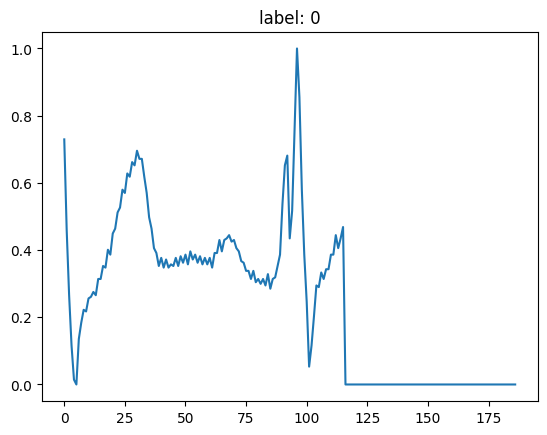

In [8]:
# visualize data
idx = np.random.randint(0, len(df_train))
print("idx: ", idx)
plt.title(f'label: {int(df_train.iloc[idx, -1])}')
plt.plot(df_train.iloc[idx, :-1].tolist())
plt.show()

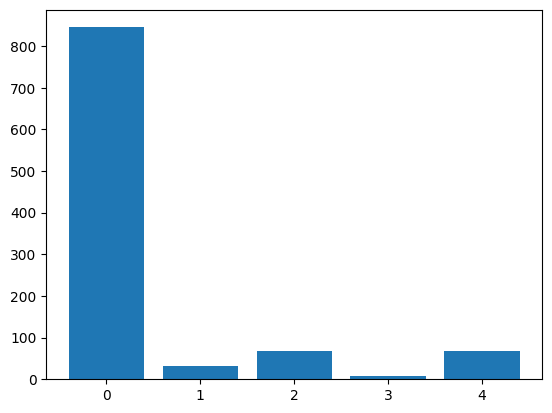

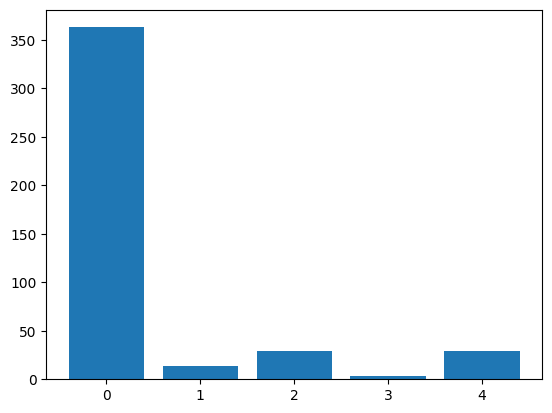

In [9]:
# draw class distribution
def plot_distibution(df):
    values, counts = np.unique(df.iloc[:, -1].tolist(), return_counts=True)
    plt.bar(range(len(values)), counts)
    plt.show()

plot_distibution(df_train)
plot_distibution(df_val)

#### Dataset

In [10]:
class ECGDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self): #資料筆數
        return len(self.df)

    def __getitem__(self, idx): #第i筆資料
        signal = self.df.iloc[idx, :-1].tolist() # (186, )長度186的訓烙
        label = self.df.iloc[idx, -1] #答案

        # add channel dim
        signal = torch.tensor(signal, dtype=torch.float).unsqueeze(0) # (1, 186)
        label = torch.tensor(label, dtype=torch.long)

        # preprocess
        signal = (signal - signal.mean()) / signal.std()

        return signal, label

train_ds = ECGDataset(df_train)
val_ds = ECGDataset(df_val)

In [11]:
signal, label = train_ds[0]
signal.shape, label.shape, label

(torch.Size([1, 187]), torch.Size([]), tensor(0))

In [12]:
# Dataloader
BATCH_SIZE = 16

train_loader = torch.utils.data.DataLoader(train_ds,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(val_ds,
                                         batch_size=BATCH_SIZE)

In [13]:
for data in train_loader:
    signals, labels = data
    print(signals.shape, labels.shape) #torch.Size([16, 1, 187]) 單通道、187個結果
    break

torch.Size([16, 1, 187]) torch.Size([16])


#### Model

In [56]:
class ECGModel(nn.Module):
    def __init__(self, num_classes, in_dim, out_dim, layers, bidirectional=False):
        super().__init__()
        self.encoder = torch.nn.LSTM(input_size=in_dim,
                                     hidden_size=out_dim,
                                     num_layers=layers,
                                     bidirectional=bidirectional
                                     )
        D = 2 if bidirectional else 1
        self.classifier = nn.Linear(D*out_dim, num_classes)

    def forward(self, inputs):
        # swap axes: (N, in_dim, L) -> (L, N, in_dim)
        inputs = inputs.permute(2, 0, 1)

        # features: (L, N, out_dim)
        features, (hn, cn) = self.encoder(inputs)

        # Method 1: Get the last step feature for each data in a batch
        # feature = features[-1, :, :] # (N, out_dim)

        # Method 2: take average of all time steps
        feature = features.mean(axis=0) #沿著時間軸的方向去做

        output = self.classifier(feature) # (N, num_classes)

        return output

model = ECGModel(num_classes=num_classes,
                 in_dim=1, #不可修
                 out_dim=64, #以修  #64個通道
                 layers=4, #可修 #兩層
                 bidirectional=True) #可修 #雙向

In [57]:
inputs = torch.rand(BATCH_SIZE, 1, 186)
outputs = model(inputs)

outputs.shape

torch.Size([16, 5])

#### Train

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0000         train_loss: 0.7562, train_acc: 0.828         val_loss: 0.7118, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0001         train_loss: 0.6685, train_acc: 0.828         val_loss: 0.6979, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0002         train_loss: 0.6560, train_acc: 0.828         val_loss: 0.6903, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0003         train_loss: 0.6453, train_acc: 0.828         val_loss: 0.6843, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0004         train_loss: 0.6381, train_acc: 0.828         val_loss: 0.6776, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0005         train_loss: 0.6108, train_acc: 0.828         val_loss: 0.5864, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0006         train_loss: 0.5617, train_acc: 0.835         val_loss: 0.6524, val_acc: 0.822 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0007         train_loss: 0.5491, train_acc: 0.836         val_loss: 0.5779, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0008         train_loss: 0.5046, train_acc: 0.855         val_loss: 0.5175, val_acc: 0.854 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0009         train_loss: 0.4545, train_acc: 0.869         val_loss: 0.4970, val_acc: 0.868 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0010         train_loss: 0.5170, train_acc: 0.870         val_loss: 0.7706, val_acc: 0.779 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0011         train_loss: 0.4786, train_acc: 0.870         val_loss: 0.4924, val_acc: 0.865 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0012         train_loss: 0.4946, train_acc: 0.880         val_loss: 0.4492, val_acc: 0.888 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0013         train_loss: 0.4464, train_acc: 0.882         val_loss: 0.4454, val_acc: 0.888 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0014         train_loss: 0.4763, train_acc: 0.876         val_loss: 0.4786, val_acc: 0.879 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0015         train_loss: 0.4474, train_acc: 0.883         val_loss: 0.4394, val_acc: 0.890 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0016         train_loss: 0.4305, train_acc: 0.890         val_loss: 0.4474, val_acc: 0.893 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0017         train_loss: 0.4171, train_acc: 0.891         val_loss: 0.4256, val_acc: 0.913 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0018         train_loss: 0.4304, train_acc: 0.892         val_loss: 0.4730, val_acc: 0.886 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0019         train_loss: 0.4060, train_acc: 0.890         val_loss: 0.4114, val_acc: 0.911 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0020         train_loss: 0.4973, train_acc: 0.866         val_loss: 0.5381, val_acc: 0.872 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0021         train_loss: 0.4460, train_acc: 0.875         val_loss: 0.4143, val_acc: 0.895 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0022         train_loss: 0.4491, train_acc: 0.874         val_loss: 0.6163, val_acc: 0.829 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0023         train_loss: 0.5186, train_acc: 0.845         val_loss: 0.4861, val_acc: 0.856 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0024         train_loss: 0.5087, train_acc: 0.863         val_loss: 0.5489, val_acc: 0.854 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0025         train_loss: 0.4599, train_acc: 0.868         val_loss: 0.4497, val_acc: 0.884 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0026         train_loss: 0.4409, train_acc: 0.881         val_loss: 0.4350, val_acc: 0.888 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0027         train_loss: 0.4214, train_acc: 0.886         val_loss: 0.4243, val_acc: 0.895 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0028         train_loss: 0.4045, train_acc: 0.887         val_loss: 0.4062, val_acc: 0.888 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0029         train_loss: 0.3979, train_acc: 0.893         val_loss: 0.3971, val_acc: 0.906 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0030         train_loss: 0.4444, train_acc: 0.873         val_loss: 0.4391, val_acc: 0.877 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0031         train_loss: 0.3997, train_acc: 0.886         val_loss: 0.3827, val_acc: 0.913 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0032         train_loss: 0.3950, train_acc: 0.894         val_loss: 0.4039, val_acc: 0.911 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0033         train_loss: 0.4080, train_acc: 0.887         val_loss: 0.3670, val_acc: 0.913 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0034         train_loss: 0.3762, train_acc: 0.895         val_loss: 0.3705, val_acc: 0.920 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0035         train_loss: 0.3583, train_acc: 0.903         val_loss: 0.3597, val_acc: 0.920 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0036         train_loss: 0.3697, train_acc: 0.894         val_loss: 0.3633, val_acc: 0.925 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0037         train_loss: 0.3635, train_acc: 0.902         val_loss: 0.3719, val_acc: 0.913 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0038         train_loss: 0.3811, train_acc: 0.898         val_loss: 0.3703, val_acc: 0.920 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0039         train_loss: 0.3563, train_acc: 0.906         val_loss: 0.3614, val_acc: 0.918 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0040         train_loss: 0.4575, train_acc: 0.861         val_loss: 0.4391, val_acc: 0.890 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0041         train_loss: 0.4381, train_acc: 0.878         val_loss: 0.4633, val_acc: 0.890 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0042         train_loss: 0.4078, train_acc: 0.885         val_loss: 0.4602, val_acc: 0.890 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0043         train_loss: 0.4455, train_acc: 0.871         val_loss: 0.5079, val_acc: 0.815 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0044         train_loss: 0.4179, train_acc: 0.872         val_loss: 0.3997, val_acc: 0.904 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0045         train_loss: 0.3667, train_acc: 0.906         val_loss: 0.4064, val_acc: 0.897 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0046         train_loss: 0.3376, train_acc: 0.910         val_loss: 0.3260, val_acc: 0.916 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0047         train_loss: 0.3069, train_acc: 0.917         val_loss: 0.3363, val_acc: 0.925 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0048         train_loss: 0.2827, train_acc: 0.924         val_loss: 0.3295, val_acc: 0.925 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0049         train_loss: 0.3137, train_acc: 0.910         val_loss: 0.3223, val_acc: 0.922 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0050         train_loss: 0.3061, train_acc: 0.902         val_loss: 0.3454, val_acc: 0.916 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0051         train_loss: 0.3080, train_acc: 0.909         val_loss: 0.3138, val_acc: 0.922 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0052         train_loss: 0.2557, train_acc: 0.929         val_loss: 0.2978, val_acc: 0.936 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0053         train_loss: 0.2420, train_acc: 0.932         val_loss: 0.2898, val_acc: 0.934 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0054         train_loss: 0.2220, train_acc: 0.940         val_loss: 0.2989, val_acc: 0.929 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0055         train_loss: 0.2244, train_acc: 0.939         val_loss: 0.3036, val_acc: 0.929 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0056         train_loss: 0.2592, train_acc: 0.932         val_loss: 0.4138, val_acc: 0.916 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0057         train_loss: 0.4117, train_acc: 0.892         val_loss: 0.3390, val_acc: 0.932 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0058         train_loss: 0.3256, train_acc: 0.913         val_loss: 0.3789, val_acc: 0.911 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0059         train_loss: 0.2811, train_acc: 0.920         val_loss: 0.4309, val_acc: 0.881 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0060         train_loss: 0.3611, train_acc: 0.892         val_loss: 0.4849, val_acc: 0.906 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0061         train_loss: 0.4457, train_acc: 0.884         val_loss: 0.4061, val_acc: 0.897 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0062         train_loss: 0.3590, train_acc: 0.900         val_loss: 0.3419, val_acc: 0.929 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0063         train_loss: 0.3408, train_acc: 0.912         val_loss: 0.3293, val_acc: 0.927 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0064         train_loss: 0.3087, train_acc: 0.910         val_loss: 0.7855, val_acc: 0.826 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0065         train_loss: 0.4661, train_acc: 0.862         val_loss: 0.4115, val_acc: 0.909 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0066         train_loss: 0.3571, train_acc: 0.904         val_loss: 0.3803, val_acc: 0.904 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0067         train_loss: 0.3019, train_acc: 0.918         val_loss: 0.3428, val_acc: 0.922 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0068         train_loss: 0.2992, train_acc: 0.915         val_loss: 0.3177, val_acc: 0.932 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0069         train_loss: 0.2749, train_acc: 0.922         val_loss: 0.3210, val_acc: 0.932 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0070         train_loss: 0.2466, train_acc: 0.934         val_loss: 0.2995, val_acc: 0.934 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0071         train_loss: 0.2184, train_acc: 0.940         val_loss: 0.2966, val_acc: 0.932 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0072         train_loss: 0.2175, train_acc: 0.944         val_loss: 0.3046, val_acc: 0.934 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0073         train_loss: 0.2045, train_acc: 0.940         val_loss: 0.3133, val_acc: 0.936 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0074         train_loss: 0.2157, train_acc: 0.944         val_loss: 0.2962, val_acc: 0.932 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0075         train_loss: 0.1872, train_acc: 0.943         val_loss: 0.2911, val_acc: 0.934 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0076         train_loss: 0.1914, train_acc: 0.943         val_loss: 0.2814, val_acc: 0.941 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0077         train_loss: 0.1868, train_acc: 0.943         val_loss: 0.2907, val_acc: 0.941 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0078         train_loss: 0.1871, train_acc: 0.940         val_loss: 0.3200, val_acc: 0.927 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0079         train_loss: 0.2327, train_acc: 0.932         val_loss: 0.3233, val_acc: 0.932 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0080         train_loss: 0.1969, train_acc: 0.942         val_loss: 0.3411, val_acc: 0.929 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0081         train_loss: 0.2038, train_acc: 0.942         val_loss: 0.3214, val_acc: 0.929 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0082         train_loss: 0.2078, train_acc: 0.933         val_loss: 0.3075, val_acc: 0.929 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0083         train_loss: 0.1711, train_acc: 0.946         val_loss: 0.3169, val_acc: 0.938 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0084         train_loss: 0.1742, train_acc: 0.948         val_loss: 0.3263, val_acc: 0.934 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0085         train_loss: 0.1506, train_acc: 0.957         val_loss: 0.2990, val_acc: 0.927 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0086         train_loss: 0.1521, train_acc: 0.959         val_loss: 0.3117, val_acc: 0.934 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0087         train_loss: 0.1602, train_acc: 0.948         val_loss: 0.2983, val_acc: 0.936 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0088         train_loss: 0.1410, train_acc: 0.959         val_loss: 0.2910, val_acc: 0.945 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0089         train_loss: 0.1345, train_acc: 0.961         val_loss: 0.2656, val_acc: 0.950 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0090         train_loss: 0.1114, train_acc: 0.966         val_loss: 0.2908, val_acc: 0.938 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0091         train_loss: 0.1127, train_acc: 0.970         val_loss: 0.2769, val_acc: 0.945 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0092         train_loss: 0.1163, train_acc: 0.968         val_loss: 0.2839, val_acc: 0.947 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0093         train_loss: 0.1134, train_acc: 0.970         val_loss: 0.2923, val_acc: 0.927 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0094         train_loss: 0.1431, train_acc: 0.958         val_loss: 0.3146, val_acc: 0.932 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0095         train_loss: 0.2139, train_acc: 0.936         val_loss: 0.2762, val_acc: 0.929 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0096         train_loss: 0.1802, train_acc: 0.942         val_loss: 0.3193, val_acc: 0.938 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0097         train_loss: 0.1599, train_acc: 0.951         val_loss: 0.3984, val_acc: 0.893 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0098         train_loss: 0.1879, train_acc: 0.939         val_loss: 0.2963, val_acc: 0.943 


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0099         train_loss: 0.1614, train_acc: 0.953         val_loss: 0.2984, val_acc: 0.943 


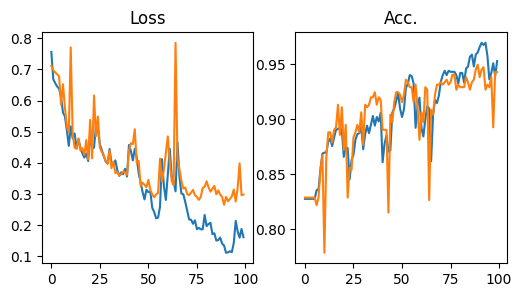

In [58]:
def train_epoch(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.train() # Sets the model in training mode.
    epoch_loss, epoch_correct = 0, 0
    for batch_i, (x, y) in enumerate(tqdm(dataloader, leave=False)):
        x, y = x.to(device), y.to(device) # move data to GPU

        # Compute prediction loss
        pred = model(x)
        loss = loss_fn(pred, y)

        # Optimization by gradients
        optimizer.zero_grad() # set prevision gradient to 0
        loss.backward() # backpropagation to compute gradients
        optimizer.step() # update model params

        # log
        epoch_loss += loss.item()
        epoch_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    # return avg loss of epoch, acc of epoch
    return epoch_loss/num_batches, epoch_correct/size


def test_epoch(dataloader, model, loss_fn, device):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.eval() # Sets the model in test mode.
    epoch_loss, epoch_correct = 0, 0

    # No training for test data
    with torch.no_grad():
        for batch_i, (x, y) in enumerate(tqdm(dataloader, leave=False)):
            x, y = x.to(device), y.to(device)

            # Compute prediction loss
            pred = model(x)
            loss = loss_fn(pred, y)

            # write to logs
            epoch_loss += loss.item()
            epoch_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    return epoch_loss/num_batches, epoch_correct/size

def train(model, epochs, train_loader, val_loader):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
    loss_fn = nn.CrossEntropyLoss() # Softmax + NLLLoss
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    logs = {
        'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []
    }
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_epoch(train_loader, model, loss_fn, optimizer, device)
        val_loss, val_acc = test_epoch(val_loader, model, loss_fn, device)

        print(f'EPOCH: {epoch:04d} \
        train_loss: {train_loss:.4f}, train_acc: {train_acc:.3f} \
        val_loss: {val_loss:.4f}, val_acc: {val_acc:.3f} ')

        logs['train_loss'].append(train_loss)
        logs['train_acc'].append(train_acc)
        logs['val_loss'].append(val_loss)
        logs['val_acc'].append(val_acc)

    # plot result
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.plot(logs['train_loss'])
    plt.plot(logs['val_loss'])
    plt.subplot(1, 2, 2)
    plt.title('Acc.')
    plt.plot(logs['train_acc'])
    plt.plot(logs['val_acc'])
    plt.show()

    # Save model
    # torch.save(model, MODEL_PATH)

train(model, 100, train_loader, val_loader)

#### Evaluation

In [63]:
from sklearn.metrics import classification_report

In [64]:
model.eval()
model.to(device)
device = "cuda" if torch.cuda.is_available() else "cpu"

y_pred = []
y_true = []
with torch.no_grad():
    for data in tqdm(val_loader):
        x, y = data
        x = x.to(device)
        pred = model(x)
        y_pred.append(pred)
        y_true.append(y)

y_pred = torch.cat(y_pred, dim=0)
y_true = torch.cat(y_true, dim=0)

  0%|          | 0/28 [00:00<?, ?it/s]

In [65]:
y_pred = y_pred.argmax(1).cpu().numpy()
y_true = y_true.numpy()

* 0.83  
model = ECGModel(num_classes=num_classes,in_dim=1, #不可修out_dim=64, #以修  #64個通道layers=2, #可修 #兩層bidirectional=True) #可修 #雙向
* 0.83  
model = ECGModel(num_classes=num_classes,in_dim=1, #不可修out_dim=64, #以修  #64個通道layers=6, #可修 #兩層bidirectional=True) #可修 #雙向
* 0.83  
model = ECGModel(num_classes=num_classes,in_dim=1, #不可修out_dim=64, #以修  #64個通道layers=6, #可修 #兩層bidirectional=false) #可修 #雙向
* 0.83  
model = ECGModel(num_classes=num_classes,in_dim=1, #不可修out_dim=128, #以修  #64個通道layers=6, #可修 #兩層bidirectional=false) #可修 #雙向
* 0.83  
model = ECGModel(num_classes=num_classes,in_dim=1, #不可修out_dim=128, #以修  #64個通道layers=10, #可修 #兩層bidirectional=True) #可修 #雙向
* 0.83  
model = ECGModel(num_classes=num_classes,in_dim=1, #不可修out_dim=128, #以修  #64個通道layers=2, #可修 #兩層bidirectional=True FROPOUT=0.5) #可修 #雙向
* 0.83  
model = ECGModel(num_classes=num_classes,in_dim=1, #不可修out_dim=64, #以修  #64個通道layers=10, #可修 #兩層bidirectional=True FROPOUT=0.5) #可修 #雙向
* 0.92
feature = features.mean(axis=0)
model = ECGModel(num_classes=num_classes,in_dim=1, #不可修out_dim=16, #以修  #64個通道layers=2, #可修 #兩層bidirectional=True ) #可修 #雙向
* 0.82
feature = features.mean(axis=0)
model = ECGModel(num_classes=num_classes,in_dim=1, #不可修out_dim=16, #以修  #64個通道layers=2, #可修 #兩層bidirectional=True ) #可修 #雙向


In [66]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       363
           1       0.75      0.21      0.33        14
           2       0.88      0.76      0.81        29
           3       1.00      0.33      0.50         3
           4       0.96      0.93      0.95        29

    accuracy                           0.94       438
   macro avg       0.91      0.65      0.71       438
weighted avg       0.94      0.94      0.93       438

